In [2]:
import pandas as pd
from pymongo import MongoClient
import cv2
import numpy as np
import matplotlib.pyplot as plt

import json


client = MongoClient(host='0.0.0.0',
                     port=27017,
                     username='root',
                     password='pass',
                     authSource="admin")
mydb = client['imgdb_notebooks']
collection = mydb['img']


In [6]:
### load csv and insert resized img to mongo db 
data = np.genfromtxt('img.csv', delimiter=',', encoding=None, dtype=None)

np_image = data[1:, 1:]
depth = data[1:, 0]

img_height, img_width = np_image.shape
w_resize_to = 150
ratio = w_resize_to / img_width
new_width = int(img_width * ratio)
new_height = int(img_height * ratio)
headers = data[0:1, 1:new_width + 1]
np_image[np_image == ''] = 0

img_resized_db = cv2.resize(np_image.astype(float), (new_width, new_height), interpolation=cv2.INTER_LINEAR)

header_col_flat_list = [item for elem in headers.tolist() for item in elem]

df_img = pd.DataFrame(data=img_resized_db[0:new_height, 0:new_width], index=depth[:new_height],
                              columns=header_col_flat_list)

df_img_db = pd.DataFrame(data=df_img, index=depth[:new_height], columns=header_col_flat_list)
df_img_db.index.name = 'depth'
df_img_db.reset_index(inplace=True)
try:
    records = df_img_db.to_dict('records')
    collection.delete_many({})
    collection.insert_many(records)
    print("records sucessufully inserted to db")
except Exception as e:
    print("errors on insert", e)

records sucessufully inserted to db


True

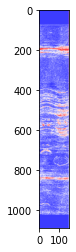

In [7]:
#load data from mongodb and get img with depth param min,  max and cmap code


def get_mpl_colormap(cmap_name):
    cmap = plt.get_cmap(cmap_name)
    # Initialize the matplotlib color map
    sm = plt.cm.ScalarMappable(cmap=cmap)
    color_range = sm.to_rgba(np.linspace(0, 1, 256), bytes=True)[:, 2::-1]
    return color_range.reshape(256, 1, 3)

# depth params
depth_max=9109.2
depth_min=9000.1
cmap = 'bwr'

result = collection.find( {} , {'_id': False})

df_img_db = pd.DataFrame(data=list(result))

df_img_db =df_img_db.set_index('depth')
df_img_db['depth'] = df_img_db.index.astype(float)

np_img = df_img_db.loc[(df_img_db["depth"] > depth_min) & 
                       (df_img_db["depth"] < depth_max)] # load frame by dpeth min and max


arr8 = np_img.iloc[:,1:].values.astype(np.uint8) 
image_bgr = cv2.applyColorMap(arr8, get_mpl_colormap(cmap)) # apply color map to frame

plt.imshow(image_bgr)
cv2.imwrite('img_{0}_{1}.png'.format(depth_min,depth_min), image_bgr)

True

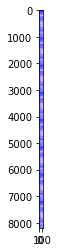

In [5]:

# get img from db and apply a color map to it
my_data = list(map(lambda x: list(x.values()), collection.find({},{"_id":0,"depth":0})))

result = np.array(my_data)

arr8 = (result).astype(np.uint8)
image_bgr = cv2.applyColorMap(arr8, get_mpl_colormap(cmap))

plt.imshow(image_bgr)
cv2.imwrite('img.jpg', image_bgr)